# Homework 4

## FINM 35700 - Spring 2024

### UChicago Financial Mathematics

### Due Date: 2025-04-22

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

Interest Rate & Credit Default Swaps
- the SOFR OIS symbology file `sofr_swap_symbology`,
- the SOFR swaps market data file `sofr_swaps_market_data_eod`,
- the CDS spreads market data file `cds_market_data_eod`.

HYG ETF corporate bonds:
- the HYG bond symbology file `hyg_bond_symbology` and
- the HYG basket composition file (containing bond weights and yields) `hyg_basket_composition`.

In [1]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

-----------------------------------------------------------
# Problem 1: Fixed rate bond prices and sensitivities (bond yield model)

## When computing sensitivities, assume "everything else being equal" (ceteris paribus).

For a better understanding of dependencies, you can use the simple fixed rate bond valuation formula in the flat yield model (formula [6] in Lecture 1).

\begin{align}
PV_{Bond}\left(c,T,y_{sa} \right)=1+\frac{c-y_{sa}}{y_{sa}}\cdot\left[1-\left(1+\frac{y_{sa}}{2}\right)^{-2T}\right]
\end{align}


## a. True or False (fixed rate bond prices)

1. Fixed rate bond price is increasing in yield. - **False**
2. Fixed rate bond price is increasing in coupon - **True**
3. Fixed rate bond price is increasing in bond maturity - **True**
4. Fixed rate callable bond prices are higher or equal to their "bullet" (non-callable) version. - **False**


## b. True or False (fixed rate bond yields)

1. Fixed rate bond yield is increasing in interest rate (assuming credit spread unchanged) - **True**  
2. Fixed rate bond yield is increasing in credit spread (assuming interest rate unchanged) - **True**
3. Fixed rate bond yield is increasing in coupon - **False**
4. Fixed rate bond yield is increasing in bond maturity (assume term structure of yield curve is known) - **False**


## c. True or False (fixed rate bond durations)

1. Fixed rate bond duration is increasing with yield - **False**
2. Fixed rate bond duration is increasing in coupon - **False**
3. Fixed rate bond duration is increasing with bond maturity - **True**
4. Fixed rate callable bond durations are higher or equal to their "bullet" (non-callable) version. - **False**


## d. True or False (fixed rate bond convexities)

1. Fixed rate bond convexity is increasing with yield - **False**
2. Fixed rate bond convexity is increasing in coupon - **False**
3. Fixed rate bond convexity is increasing with bond maturity - **True**
4. Fixed rate callable bond convexities are higher or equal to their "bullet" (non-callable) version. - **False**


-----------------------------------------------------------
# Problem 2: US SOFR swap curve calibration as of 2024-12-13
### Follow Section "1. SOFR OIS swap rates and SOFR discount curve calibration + validation" in the QuantLib Advanced notebook !

## a. Load and explore US SOFR swaps symbology and market data

Load the `sofr_swap_symbology` Excel file into a dataframe. Print all swap tenors available.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Plot the historial time series of SOFR rates for the available [1Y, 2Y, 3Y, 5Y, 7Y, 10Y, 20Y, 30Y] tenors.

In [2]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'SOFR Swap Rates')

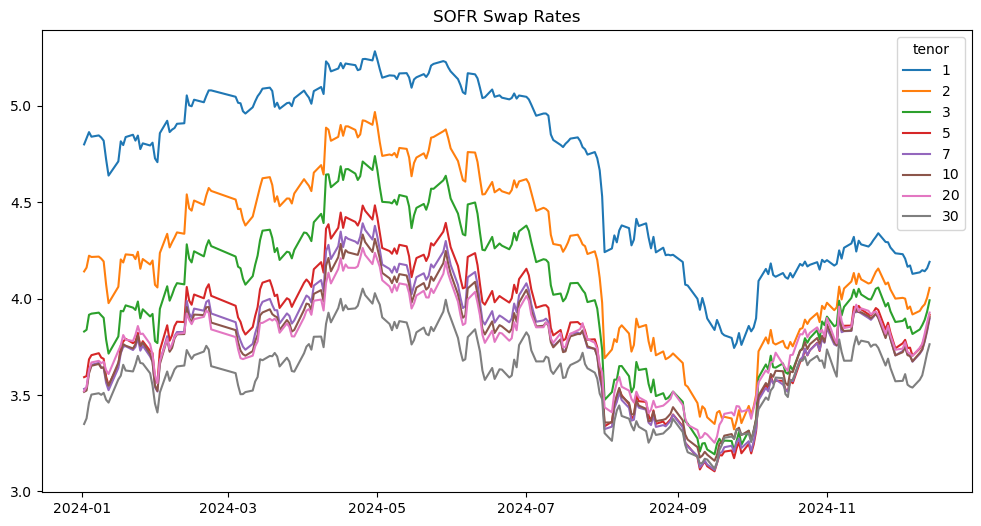

In [3]:
sofr_symbology = pd.read_excel('./data/sofr_swaps_symbology.xlsx')
sofr_market = pd.read_excel('./data/sofr_swaps_market_data_eod.xlsx')
sofr_joined = pd.merge(sofr_symbology, sofr_market, on='figi', how='inner')
sofr_joined.sort_values(by='date', inplace=True)
fig, ax = plt.subplots(figsize=(12, 6))
for name, group in sofr_joined.groupby('tenor'):
    ax.plot(group['date'], group['midRate'], label = name)
plt.legend(title='tenor')
plt.title('SOFR Swap Rates')

## b. Calibrate the US SOFR yield curve (via bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from SOFR swaps. 

Prepare a joint symbology & market dataframe quotes as of 2024-12-13. 

Calibrate the SOFR discount factor curve as of 2024-12-13.

Follow section 1b in the QuantLib Advanced notebook.

In [4]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='tenor')    
    
    # settle_days
    settle_days = 1
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['tenor']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [5]:
sofr_market[sofr_market['date'] == '2024-12-13']

,date,figi,bidRate,askRate,midRate
1871,2024-12-13,BBG00KFWPJJ9,4.1858,4.1958,4.19080
1872,2024-12-13,BBG00KFWPJX3,4.0524,4.0585,4.05545
1873,2024-12-13,BBG00KFWPK15,3.9883,3.9944,3.99135
1874,2024-12-13,BBG00KFWPK51,3.9133,3.9181,3.91570
1875,2024-12-13,BBG00KFWPK79,3.8937,3.8991,3.89640
1876,2024-12-13,BBG00KFWPKB4,3.9015,3.9065,3.90400
1877,2024-12-13,BBG00KFWPKH8,3.7602,3.7662,3.76320
1878,2024-12-13,BBG00KFWPKF0,3.9246,3.9304,3.92750


In [6]:
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_joined[sofr_joined['date'] == '2024-12-13'], 'midRate')

def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df


## c. Display the calibrated SOFR discount curve dataframe

Follow section 1d (in the QuantLib Advanced notebook) to display the calibration details dataframe.

In [7]:
# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

display(sofr_yield_curve_simple_df)
display(sofr_yield_curve_details_df)


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2025-12-16,1.014,0.959,4.190
2,2026-12-16,2.028,0.923,4.052
3,2027-12-16,3.042,0.888,3.986
4,2029-12-17,5.075,0.823,3.907
5,2031-12-16,7.100,0.763,3.888
6,2034-12-18,10.150,0.678,3.899
7,2044-12-16,20.292,0.457,3.931
8,2054-12-16,30.436,0.333,3.676


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-16,0.000,1.000,4.190
1,2026-12-16,2.028,0.923,4.052
2,2028-12-16,4.058,0.855,3.946
3,2030-12-16,6.086,0.792,3.897
4,2032-12-16,8.117,0.734,3.892
5,2034-12-16,10.144,0.678,3.899
6,2036-12-16,12.175,0.627,3.905
7,2038-12-16,14.203,0.580,3.912
8,2040-12-16,16.233,0.536,3.918
9,2042-12-16,18.261,0.495,3.925


## d. Plot the calibrated US SOFR Zero Interest Rates and Discount Factor curves

Plot the SOFR zero rates and discount factor curves by maturity. Follow section 1c in the QuantLib Advanced notebook.

Text(0.5, 0, 'Date')

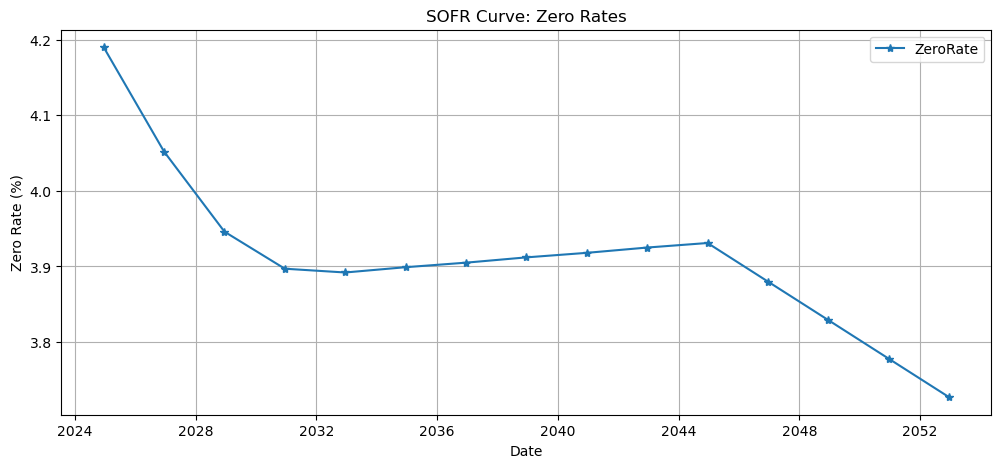

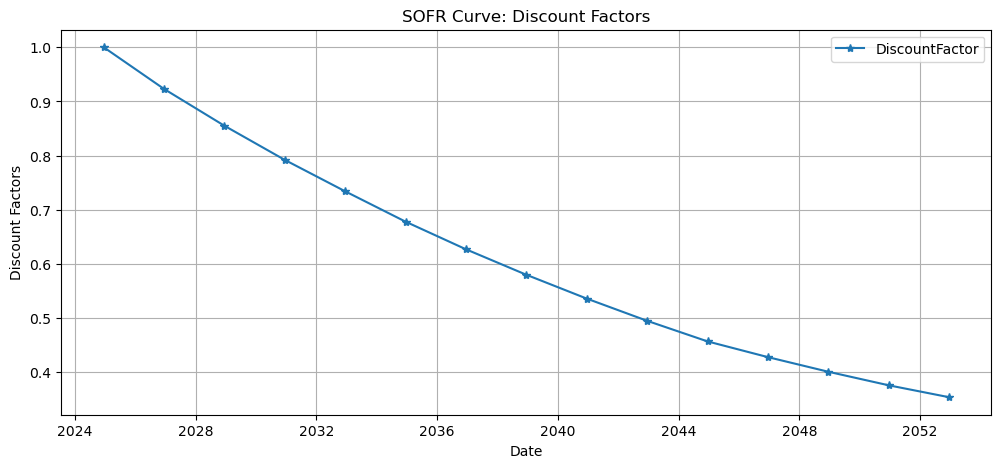

In [8]:
rates = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates', figsize=(12,5))
rates.set_ylabel('Zero Rate (%)')
rates.set_xlabel('Date')

discs = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors', figsize=(12,5))
discs.set_ylabel('Discount Factors')
discs.set_xlabel('Date')

-----------------------------------------------------------
# Problem 3: CDS Hazard Rate calibration and valuation
## Follow Section "2. CDS Hazard Rate calibration + Pricing" in the QuantLib Advanced notebook !!!

## a. Load and explore the CDS market data (IBM credit issuer)

Load the `cds_market_data_eod` Excel file into a dataframe. 

Plot the historical time series of CDS Par Spreads for the available tenors.


Text(0.5, 1.0, 'CDS Par Spreads')

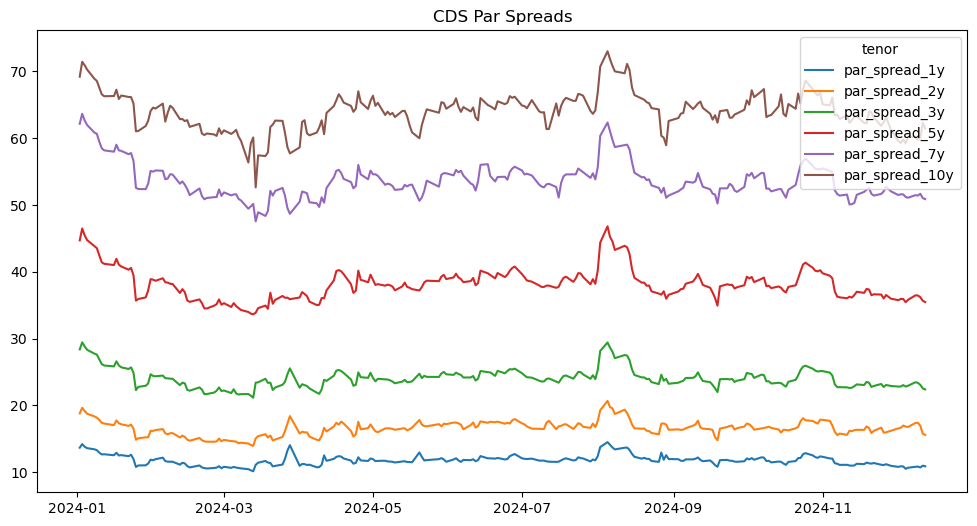

In [9]:
cds_market = pd.read_excel('./data/cds_market_data_eod.xlsx')
cds_market.sort_values(by='date', inplace=True)
columns = ['par_spread_1y', 'par_spread_2y', 'par_spread_3y', 'par_spread_5y', 'par_spread_7y', 'par_spread_10y']
plt.figure(figsize=(12, 6))
for column in columns:
    plt.plot(cds_market['date'], cds_market[column], label=column)
plt.legend(title='tenor', loc='upper right')
plt.title('CDS Par Spreads')

In [10]:
cds_market.cds_assumed_recovery.unique()

array([0.4])

## b. Calibrate the IBM hazard rate curve as of 2024-12-13

Follow section 2a in the QuantLib Advanced notebook. Use the calibrated SOFR discount curve from Problem 2b.

In [11]:
cds_ibm = cds_market[cds_market['date'] == '2024-12-13']
cds_ibm

,date,ticker,short_name,tier,sector,region,currency,doc_clause,running_coupon,cds_assumed_recovery,par_spread_1y,par_spread_2y,par_spread_3y,par_spread_5y,par_spread_7y,par_spread_10y
238,2024-12-13,IBM,Intl Business Machs Corp,SNRFOR,Technology,N.Amer,USD,XR14,0.01,0.4,10.9082,15.6009,22.4095,35.4733,50.8816,61.462


In [12]:
cds_ibm = cds_market[cds_market['date'] == '2024-12-13']
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)
settle_days = 1

CDS_recovery_rate = cds_ibm['cds_assumed_recovery'].iloc[0]
CDS_day_count = ql.Actual360()
# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2024-12-13
CDS_spreads = cds_ibm[columns].iloc[0, :].values#[17.25, 24.09, 35.58, 55.58, 70.51, 79.92]

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)               
                for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                hazard_rate_curve.survivalProbability(hr[0])) 
                for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
print(hazard_rates_df)


         Date   YearFrac  HazardRate  SurvivalProb
0  2024-12-13   0.000000    0.179862      1.000000
1  2025-12-22   1.038889    0.179862      0.998133
2  2026-12-21   2.050000    0.341810      0.994690
3  2027-12-20   3.061111    0.614840      0.988525
4  2029-12-20   5.091667    0.953377      0.969572
5  2031-12-22   7.125000    1.604396      0.938453
6  2034-12-20  10.163889    1.551602      0.895230


## c. Plot the calibrated Hazard Rates and Survival Probability curves
Follow section 2b in the QuantLib Advanced notebook. Use the calibrated SOFR discount curve from Problem 2b.

Text(0.5, 0, 'Date')

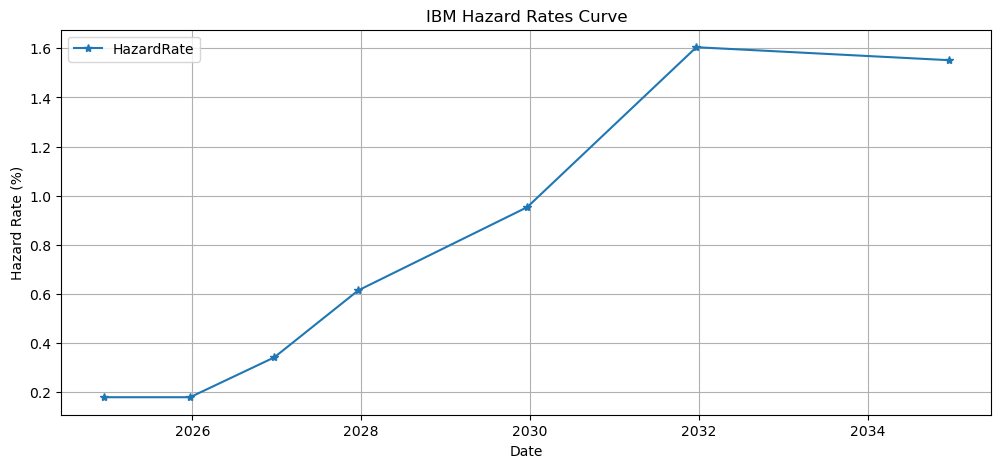

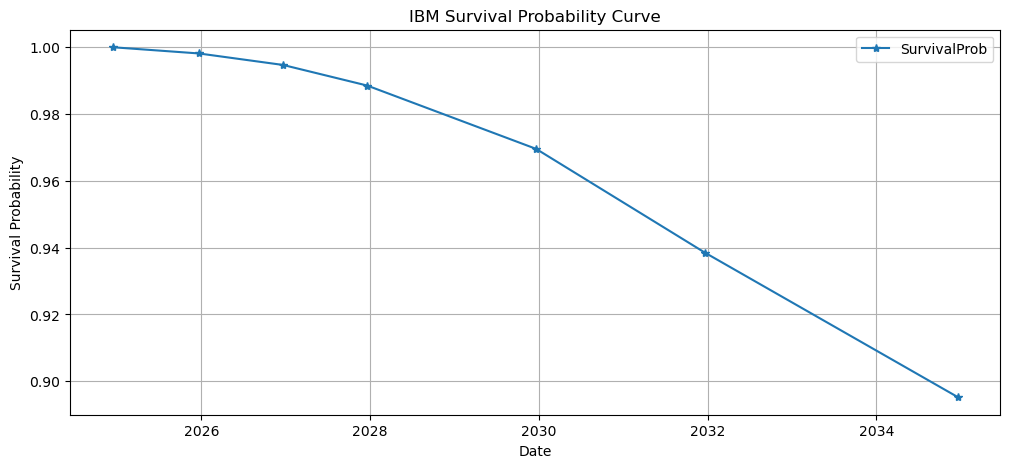

In [13]:
h_rates = hazard_rates_df.plot(x='Date', y='HazardRate', grid=True, style='*-', title='IBM Hazard Rates Curve', figsize=(12,5))
h_rates.set_ylabel('Hazard Rate (%)')
h_rates.set_xlabel('Date')

prob = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve', figsize=(12,5))
prob.set_ylabel('Survival Probability')
prob.set_xlabel('Date')


## d. Compute the fair/par spread and PV of a 5 year CDS contract

Follow section 2c in the QuantLib Advanced notebook. Construct a CDS object with 100 bps coupon and 2029-06-20 maturity. Compute the fair/par spread and PV.


In [14]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(13, 12, 2024)
cds_maturity_date = ql.Date(20, 6, 2029)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# display(list(cds_schedule))

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS Implied Credit Curve and pricing engine
cds_surv_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

cds_pricing_engine = ql.MidPointCdsEngine(cds_surv_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_pricing_engine)


# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))


CDS protection start date: December 13th, 2024
CDS fair/par spread: 33.238
CDS PV: 2.7634
CDS Premium Leg PV: 4.1391
CDS Default Leg PV -1.3758
Survival Prob. to Maturity: 0.9743


-----------------------------------------------------------
# Problem 4: Credit ETF analysis on HYG (iShares High Yield Corporate Bond ETF)

## a. Load and explore the HYG basket composition and market data

Load the `hyg_basket_composition` Excel file into a dataframe. It contains the HYG basket constituent face notionals, weights and yields-to-maturities as of 2024-12-13.

Load the `hyg_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for HYG constituents.

How many corporate bonds are in the HYG basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the HYG basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [15]:
hyg_basket = pd.read_excel('./data/hyg_basket_composition.xlsx')
hyg_corps = pd.read_excel('./data/hyg_corp_symbology.xlsx')

In [16]:
print(f'Number of Corporate Bonds in HYG Basket: {hyg_basket['isin'].nunique()}')
print('Median and Average Face Notionals per bond: ')
print(f'Median: {hyg_basket.face_notional.median()}')
print(f'Average: {hyg_basket.face_notional.mean()}')

Number of Corporate Bonds in HYG Basket: 1233
Median and Average Face Notionals per bond: 
Median: 11267000.0
Average: 13191517.437145174


In [17]:
hyg_basket.set_index(['isin', 'figi'], inplace=True)
hyg_corps.set_index(['isin', 'figi'], inplace=True)
cols = hyg_corps.columns.difference(hyg_basket.columns)
hyg_full = pd.merge(hyg_basket, hyg_corps[cols], left_index=True, right_index=True, how='inner').reset_index()

In [18]:
print("Number of Unique Tickers in HYG Basket: ", hyg_full['ticker'].nunique())
print("Median and Average Face Notionals per ticker: ")
display(hyg_full.groupby('ticker')['face_notional'].agg(['median', 'mean']).reset_index())
print("Mean, Median and Std Dev of Yield to Maturities per bond: \n", hyg_full['midYield'].agg(['mean', 'median', 'std']))

Number of Unique Tickers in HYG Basket:  415
Median and Average Face Notionals per ticker: 


,ticker,median,mean
0,AA,7486500.0,7924500.0
1,AAL,13823500.0,13823500.0
2,AAP,8373000.0,8373000.0
3,ABCSUP,7635500.0,7635500.0
4,ABG,7998000.0,8685750.0
...,...,...,...
410,XRX,10162000.0,10162000.0
411,YUM,15599000.0,14074200.0
412,ZAYO,20570500.0,20570500.0
413,ZFFNGR,10598000.0,10639000.0


Mean, Median and Std Dev of Yield to Maturities per bond: 
 mean      7.375438
median    6.139500
std       6.981988
Name: midYield, dtype: float64


## b. Compute the NAV of the HYG basket and the intrinsic price of one ETF share.

Create the bond objects for all constituents of HYG. Compute the dirty price for each bond (from yield-to-maturity).

Aggregate the ETF NAV value (intrisic value of bond basket) as the weighted sum of dirty prices times basket weights. Keep in mind that the resulting ETF NAV will be on a face of $100, since the basket face notional weights add up to 100 percent.

Compute the intrinisc market capitalization of the HYG ETF by scaling the ETF NAV price to the ETF total face notional. 

Divide by 195,600,000 (the number of ETF shared outstanding as of 2024-12-13) to obtain the intrinsic USD price of one HYG ETF share.

As a reference, the market price of each HYG share on 2024-12-13 was $79.41, and the NAV was $79.45.

In [19]:
day_count = ql.Thirty360(ql.Thirty360.USA)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
cpn_freq = ql.Semiannual
compounding = ql.Compounded

In [20]:
bond_objs = []
bond_nav = []
bond_dprices = []
for _,row in hyg_full.iterrows():
    obj = create_bond_from_symbology(row)
    bond_dprices.append(obj.dirtyPrice(row['midYield']/100, day_count, compounding, cpn_freq))
hyg_full['dirtyPrice'] = bond_dprices

In [21]:
etf_nav = ((hyg_full['dirtyPrice']*hyg_full['face_notional_weight']/100).sum())
mkt_cap = (hyg_full['dirtyPrice']*hyg_full['face_notional']/100).sum()
print(f'ETF NAV for per $100 Face: {etf_nav}')
print(f'ETF Intrinsic Market Cap: {mkt_cap}')
print(f'Intrinsic Price per share: {mkt_cap/195600000}')

ETF NAV for per $100 Face: 100.0320420832138
ETF Intrinsic Market Cap: 15540503662.169605
Intrinsic Price per share: 79.4504277207035


## c. Compute the ETF yield using the ACF (Aggregated Cash-Flows) method

Create the bond objects for all constituents of HYG. 

Write a function that computes the ETF NAV for a given flat yield y.

Use a numerical root finder (e.g. root_scalar from scipy.optimize) to solve for 

- ETF_NAV(yield) = ETF_NAV_Price 

and obtain the ETF yield.

As a reference, the HYG market yield as of 2024-12-13 was around 7%.

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import scipy.optimize as opt
etf_price = 79.45

def etf_nav_solver(yld):
    yld = float(yld)
    val = 0
    for _,row in hyg_full.iterrows():
        obj = create_bond_from_symbology(row)
        val += (obj.dirtyPrice(yld/100, day_count, compounding, cpn_freq) * row['face_notional_weight']/100)
    return val

etf_price = 79.45
def obj_yield(nav_price):
    f = lambda x: etf_nav_solver(x) - nav_price
    sol = opt.root_scalar(f, x0 = 0.03, xtol=1e-8)
    return sol.root

print(f'ETF Yield: {obj_yield(etf_nav):.4f}%')

ETF Yield: 7.0389%


Add a root finder wrapper function (e.g. root_scalar in scipy.optimize ) and solve for the ETF yield.

## d. Compute the ETF DV01 and Duration

Treat the ETF basket as a synthetic bond.

Use - 1 bp scenarios in ETF yield space to compute the ETF DV01 and Duration.

As a reference, the HYG risk metrics as of 2024-12-13 are: DV01 of 3.82, Duration of 3.82.

In [24]:
import numpy as np

etf_yield_pct = obj_yield(etf_nav)
print(f"Computed ETF Yield (percent): {etf_yield_pct:.4f}%")

bp = 0.01
price_down = etf_nav_solver(etf_yield_pct - bp)

dv01 = (price_down - etf_nav)*100
print(f"ETF DV01: {dv01:.4f}")

modified_duration = dv01 / etf_nav * 100.0
print(f"ETF Duration: {modified_duration:.4f}")

Computed ETF Yield (percent): 7.0389%
ETF DV01: 3.8211
ETF Duration: 3.8198
